In [ ]:
import os

# Directories
face_dir = r'C:\Users\manog\Downloads\biometric_attendance_system\student_database\faces'
ecg_dir = r'C:\Users\manog\Downloads\ecg_augmented'

# List of missing ECG students (as integers)
missing_ecg = [16, 23, 38, 45, 53, 56, 58] + list(range(98, 141))

# Prepare mapping
mapping = []
for i in range(1, 99):  # person_1 to person_98
    if i in missing_ecg:
        continue
    face_folder = str(i)
    ecg_folder = f'person_{i}'
    face_path = os.path.join(face_dir, face_folder)
    ecg_path = os.path.join(ecg_dir, ecg_folder)
    if os.path.isdir(face_path) and os.path.isdir(ecg_path):
        mapping.append((face_folder, ecg_folder))
    else:
        print(f"Missing folder for student {i}: Face({os.path.isdir(face_path)}), ECG({os.path.isdir(ecg_path)})")

print(f"Total students with both face and ECG data: {len(mapping)}")

# Optional: Save mapping for future use
import csv
with open('face_ecg_mapping.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['face_folder', 'ecg_folder'])
    writer.writerows(mapping)



Missing folder for student 66: Face(False), ECG(False)
Missing folder for student 95: Face(False), ECG(True)
Total students with both face and ECG data: 88


In [5]:
import csv

# Suppose 'mapping' is your list of (face_folder, ecg_folder) tuples
mapping = [
    ('1', 'person_1'),
    ('2', 'person_2'),
    # ... (all mapped pairs)
    ('98', 'person_98')
]

# Write to CSV
with open('face_ecg_mapping_table.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Face Folder', 'ECG Folder', 'Status'])
    for face_folder, ecg_folder in mapping:
        writer.writerow([face_folder, ecg_folder, 'Mapped'])


In [6]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- FACE PREPROCESSING ---

def preprocess_face(img_path, img_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Data augmentation for face images
face_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# --- ECG PREPROCESSING ---

def preprocess_ecg(ecg_path):
    # Assuming ECG is stored as a numpy array or image
    # If it's an image, read and normalize; if it's a signal, load and z-score
    if ecg_path.endswith('.npy'):
        ecg = np.load(ecg_path)
    else:
        ecg = cv2.imread(ecg_path, cv2.IMREAD_GRAYSCALE)
    ecg = (ecg - np.mean(ecg)) / np.std(ecg)  # Z-score normalization
    return ecg

def augment_ecg(ecg):
    # Example: Add Gaussian noise
    noise = np.random.normal(0, 0.01, ecg.shape)
    return ecg + noise

# --- MAPPING (from previous step) ---
import pandas as pd
mapping_df = pd.read_csv('face_ecg_mapping_table.csv')

# --- EXAMPLE: Load one pair ---
face_folder = str(mapping_df.iloc[0]['Face Folder'])
ecg_folder = str(mapping_df.iloc[0]['ECG Folder'])

face_img_path = os.path.join(face_dir, face_folder, os.listdir(os.path.join(face_dir, face_folder))[0])
ecg_img_path = os.path.join(ecg_dir, ecg_folder, os.listdir(os.path.join(ecg_dir, ecg_folder))[0])

face_img = preprocess_face(face_img_path)
ecg_sig = preprocess_ecg(ecg_img_path)


In [7]:
import os
import pandas as pd

# Paths to data directories
face_dir = r'C:\Users\manog\Downloads\biometric_attendance_system\student_database\faces'
ecg_dir = r'C:\Users\manog\Downloads\ecg_augmented'

# Load mapping table
mapping_df = pd.read_csv('face_ecg_mapping_table.csv')

# Example preprocessing functions (from previous step)
def preprocess_face(img_path, img_size=(224, 224)):
    import cv2
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    return img

def preprocess_ecg(ecg_path):
    import cv2
    import numpy as np
    ecg = cv2.imread(ecg_path, cv2.IMREAD_GRAYSCALE)
    ecg = (ecg - np.mean(ecg)) / np.std(ecg)
    return ecg

# Iterate over all mapped pairs
for idx, row in mapping_df.iterrows():
    face_folder = str(row['Face Folder'])
    ecg_folder = str(row['ECG Folder'])

    face_folder_path = os.path.join(face_dir, face_folder)
    ecg_folder_path = os.path.join(ecg_dir, ecg_folder)

    # List all files in each folder (assuming images for both)
    face_files = [f for f in os.listdir(face_folder_path) if not f.startswith('.')]
    ecg_files = [f for f in os.listdir(ecg_folder_path) if not f.startswith('.')]

    # For each image pair (assuming same number and order, or use a matching strategy)
    for face_file, ecg_file in zip(face_files, ecg_files):
        face_img_path = os.path.join(face_folder_path, face_file)
        ecg_img_path = os.path.join(ecg_folder_path, ecg_file)

        # Preprocess
        face_img = preprocess_face(face_img_path)
        ecg_sig = preprocess_ecg(ecg_img_path)

        # At this point, you can:
        # - Store these in a list for batching
        # - Pass to feature extraction models
        # - Fuse features, etc.

        # Example: print shapes
        print(f"Processed: {face_img_path} & {ecg_img_path} | Face shape: {face_img.shape}, ECG shape: {ecg_sig.shape}")


Processed: C:\Users\manog\Downloads\biometric_attendance_system\student_database\faces\1\img_0.jpg & C:\Users\manog\Downloads\ecg_augmented\person_1\person_1_aug_0_1042.png | Face shape: (224, 224, 3), ECG shape: (224, 224)
Processed: C:\Users\manog\Downloads\biometric_attendance_system\student_database\faces\1\img_1.jpg & C:\Users\manog\Downloads\ecg_augmented\person_1\person_1_aug_0_2137.png | Face shape: (224, 224, 3), ECG shape: (224, 224)
Processed: C:\Users\manog\Downloads\biometric_attendance_system\student_database\faces\1\img_10.jpg & C:\Users\manog\Downloads\ecg_augmented\person_1\person_1_aug_0_3102.png | Face shape: (224, 224, 3), ECG shape: (224, 224)
Processed: C:\Users\manog\Downloads\biometric_attendance_system\student_database\faces\1\img_11.jpg & C:\Users\manog\Downloads\ecg_augmented\person_1\person_1_aug_0_4119.png | Face shape: (224, 224, 3), ECG shape: (224, 224)
Processed: C:\Users\manog\Downloads\biometric_attendance_system\student_database\faces\1\img_12.jpg & 

In [8]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv1D, MaxPooling1D

# Paths to data directories
face_dir = r'C:\Users\manog\Downloads\biometric_attendance_system\student_database\faces'
ecg_dir = r'C:\Users\manog\Downloads\ecg_augmented'

# Load mapping table
mapping_df = pd.read_csv('face_ecg_mapping_table.csv')

# Preprocessing functions
def preprocess_face(img_path, img_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    return img

def preprocess_ecg(ecg_path, img_size=(128, 128)):
    # Read ECG as image (PNG)
    ecg = cv2.imread(ecg_path, cv2.IMREAD_GRAYSCALE)
    if ecg is None:
        raise ValueError(f"Could not read image: {ecg_path}")
    ecg = cv2.resize(ecg, img_size)
    ecg = (ecg - np.mean(ecg)) / np.std(ecg)
    return ecg

# Feature extraction models
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
face_model = Model(inputs=base_model.input, outputs=base_model.output)
face_model.trainable = False

# ECG encoder (now as 2D-CNN for images)
def create_ecg_encoder(input_shape=(128, 128, 1)):
    input_ecg = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_ecg)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    embedding = Dense(128, activation='relu')(x)  # ECG embedding size
    return Model(input_ecg, embedding)

ecg_model = create_ecg_encoder()
ecg_model.summary()

# Feature extraction loop
face_embeddings = []
ecg_embeddings = []
labels = []

for idx, row in mapping_df.iterrows():
    face_folder = str(row['Face Folder'])
    ecg_folder = str(row['ECG Folder'])

    face_folder_path = os.path.join(face_dir, face_folder)
    ecg_folder_path = os.path.join(ecg_dir, ecg_folder)

    face_files = [f for f in os.listdir(face_folder_path) if not f.startswith('.')]
    ecg_files = [f for f in os.listdir(ecg_folder_path) if not f.startswith('.')]

    # Take first file for each folder
    face_img_path = os.path.join(face_folder_path, face_files[0])
    ecg_img_path = os.path.join(ecg_folder_path, ecg_files[0])

    # Preprocess face
    face_img = preprocess_face(face_img_path)
    face_img = np.expand_dims(face_img, axis=0)  # (1, 224, 224, 3)

    # Preprocess ECG (as image)
    ecg_img = preprocess_ecg(ecg_img_path)
    ecg_img = np.expand_dims(ecg_img, axis=(0, -1))  # (1, 128, 128, 1)

    # Extract features
    face_embedding = face_model.predict(face_img)
    face_embedding = face_embedding.flatten()

    ecg_embedding = ecg_model.predict(ecg_img)
    ecg_embedding = ecg_embedding.flatten()

    face_embeddings.append(face_embedding)
    ecg_embeddings.append(ecg_embedding)
    labels.append(idx)

    print(f"Extracted features for student {face_folder}")

face_embeddings = np.array(face_embeddings)
ecg_embeddings = np.array(ecg_embeddings)
labels = np.array(labels)

print("Face embeddings shape:", face_embeddings.shape)
print("ECG embeddings shape:", ecg_embeddings.shape)
print("Labels shape:", labels.shape)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,407,552 (32.07 MB)

 Trainable params: 8,407,552 (32.07 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Extracted features for student 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Extracted features for student 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Extracted features for student 98
Face embeddings shape: (3, 62720)
ECG embeddings shape: (3, 128)
Labels shape: (3,)


In [9]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Paths to data directories
face_dir = r'C:\Users\manog\Downloads\biometric_attendance_system\student_database\faces'
ecg_dir = r'C:\Users\manog\Downloads\ecg_augmented'

# Load mapping table
mapping_df = pd.read_csv('face_ecg_mapping_table.csv')

# Preprocessing functions
def preprocess_face(img_path, img_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    return img

def preprocess_ecg(ecg_path, img_size=(128, 128)):
    ecg = cv2.imread(ecg_path, cv2.IMREAD_GRAYSCALE)
    ecg = cv2.resize(ecg, img_size)
    ecg = (ecg - np.mean(ecg)) / np.std(ecg)
    return ecg

# Feature extraction models
base_face = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
face_model = Model(inputs=base_face.input, outputs=base_face.output)
face_model.trainable = False

def create_ecg_encoder(input_shape=(128, 128, 1)):
    input_ecg = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_ecg)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(input_ecg, x)

ecg_model = create_ecg_encoder()

# Feature extraction loop (use ALL samples for each student)
face_embeddings = []
ecg_embeddings = []
labels = []

for idx, row in mapping_df.iterrows():
    face_folder = str(row['Face Folder'])
    ecg_folder = str(row['ECG Folder'])
    face_folder_path = os.path.join(face_dir, face_folder)
    ecg_folder_path = os.path.join(ecg_dir, ecg_folder)
    face_files = [f for f in os.listdir(face_folder_path) if not f.startswith('.')]
    ecg_files = [f for f in os.listdir(ecg_folder_path) if not f.startswith('.')]

    # Loop through all samples for this student
    for face_file, ecg_file in zip(face_files, ecg_files):
        face_img_path = os.path.join(face_folder_path, face_file)
        ecg_img_path = os.path.join(ecg_folder_path, ecg_file)
        face_img = preprocess_face(face_img_path)
        ecg_img = preprocess_ecg(ecg_img_path)
        face_img = np.expand_dims(face_img, axis=0)
        ecg_img = np.expand_dims(ecg_img, axis=(0, -1))
        face_embedding = face_model.predict(face_img).flatten()
        ecg_embedding = ecg_model.predict(ecg_img).flatten()
        face_embeddings.append(face_embedding)
        ecg_embeddings.append(ecg_embedding)
        labels.append(idx)

face_embeddings = np.array(face_embeddings)
ecg_embeddings = np.array(ecg_embeddings)
labels = np.array(labels)

# Feature fusion
fused_features = np.concatenate([face_embeddings, ecg_embeddings], axis=1)

# Label encoding and one-hot
le = LabelEncoder()
y = le.fit_transform(labels)
y = to_categorical(y)

# Train/test split (stratified if enough samples per class, otherwise use random)
# If you have at least 2 samples per student, use stratify=y
if np.min(np.bincount(y.argmax(axis=1))) >= 2:
    X_train, X_test, y_train, y_test = train_test_split(fused_features, y, test_size=0.2, stratify=y, random_state=42)
else:
    X_train, X_test, y_train, y_test = train_test_split(fused_features, y, test_size=0.2, random_state=42)

# Build and train model
model = tf.keras.Sequential([
    Dense(256, activation='relu', input_shape=(fused_features.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━

c:\Users\manog\Downloads\biometric_attendance_system\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - accuracy: 0.2986 - loss: 3.8583 - val_accuracy: 1.0000 - val_loss: 3.9736e-08
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8368 - loss: 4.5237 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9375 - loss: 2.0637 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9236 - loss: 2.4577 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9514 - loss: 0.3838 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9479 - loss: 2.2111 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9618 - loss: 0.8531 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9757 - loss: 0.1533 - val_

In [10]:
model = tf.keras.Sequential([
    Dense(256, activation='relu', input_shape=(fused_features.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 561ms/step - accuracy: 0.3785 - loss: 4.0662 - val_accuracy: 1.0000 - val_loss: 0.0291
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7882 - loss: 3.2216 - val_accuracy: 1.0000 - val_loss: 9.9341e-09
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8993 - loss: 2.1155 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8472 - loss: 7.2517 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9132 - loss: 1.8174 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9514 - loss: 2.9163 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9514 - loss: 1.1744 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9757 - loss: 0.4814 - val_accu

In [11]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Accuracy: 1.0000


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Confusion Matrix:
[[4 0 0]
 [0 4 0]
 [0 0 4]]


In [13]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Paths to data directories
face_dir = r'C:\Users\manog\Downloads\biometric_attendance_system\student_database\faces'
ecg_dir = r'C:\Users\manog\Downloads\ecg_augmented'

# Load mapping table
mapping_df = pd.read_csv('face_ecg_mapping_table.csv')

# Preprocessing functions
def preprocess_face(img_path, img_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    return img

def preprocess_ecg(ecg_path, img_size=(128, 128)):
    ecg = cv2.imread(ecg_path, cv2.IMREAD_GRAYSCALE)
    ecg = cv2.resize(ecg, img_size)
    ecg = (ecg - np.mean(ecg)) / np.std(ecg)
    return ecg

# Feature extraction models
base_face = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
face_model = Model(inputs=base_face.input, outputs=base_face.output)
face_model.trainable = False

def create_ecg_encoder(input_shape=(128, 128, 1)):
    input_ecg = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_ecg)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(input_ecg, x)

ecg_model = create_ecg_encoder()

# Feature extraction loop (loop through ALL samples for each student)
face_embeddings = []
ecg_embeddings = []
labels = []

for idx, row in mapping_df.iterrows():
    face_folder = str(row['Face Folder'])
    ecg_folder = str(row['ECG Folder'])
    face_folder_path = os.path.join(face_dir, face_folder)
    ecg_folder_path = os.path.join(ecg_dir, ecg_folder)

    # List all files in each folder (assuming same number and order, or use a matching strategy)
    face_files = sorted([f for f in os.listdir(face_folder_path) if not f.startswith('.')])
    ecg_files = sorted([f for f in os.listdir(ecg_folder_path) if not f.startswith('.')])

    # Ensure we have the same number of samples per student
    min_samples = min(len(face_files), len(ecg_files))
    face_files = face_files[:min_samples]
    ecg_files = ecg_files[:min_samples]

    for face_file, ecg_file in zip(face_files, ecg_files):
        face_img_path = os.path.join(face_folder_path, face_file)
        ecg_img_path = os.path.join(ecg_folder_path, ecg_file)

        # Preprocess face
        face_img = preprocess_face(face_img_path)
        face_img = np.expand_dims(face_img, axis=0)  # (1, 224, 224, 3)

        # Preprocess ECG (as image)
        ecg_img = preprocess_ecg(ecg_img_path)
        ecg_img = np.expand_dims(ecg_img, axis=(0, -1))  # (1, 128, 128, 1)

        # Extract features
        face_embedding = face_model.predict(face_img, verbose=0).flatten()
        ecg_embedding = ecg_model.predict(ecg_img, verbose=0).flatten()

        face_embeddings.append(face_embedding)
        ecg_embeddings.append(ecg_embedding)
        labels.append(idx)

face_embeddings = np.array(face_embeddings)
ecg_embeddings = np.array(ecg_embeddings)
labels = np.array(labels)

# Feature fusion
fused_features = np.concatenate([face_embeddings, ecg_embeddings], axis=1)

print("Face embeddings shape:", face_embeddings.shape)
print("ECG embeddings shape:", ecg_embeddings.shape)
print("Labels shape:", labels.shape)
print("Fused features shape:", fused_features.shape)


Face embeddings shape: (60, 62720)
ECG embeddings shape: (60, 128)
Labels shape: (60,)
Fused features shape: (60, 62848)


In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(fused_features)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance; or set n_components=50
X_pca = pca.fit_transform(X_scaled)

print("Reduced features shape:", X_pca.shape)


Reduced features shape: (60, 42)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# If you have not already encoded labels as integers
le = LabelEncoder()
y = le.fit_transform(labels)

# Split data
if np.min(np.bincount(y)) >= 2:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, stratify=y, random_state=42)
else:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_cat, epochs=50, batch_size=8, validation_data=(X_test, y_test_cat))


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2774 - loss: 21.7353 - val_accuracy: 0.5000 - val_loss: 3.4767
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4548 - loss: 14.7397 - val_accuracy: 0.7500 - val_loss: 3.0915
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4637 - loss: 15.2327 - val_accuracy: 0.7500 - val_loss: 2.9520
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5500 - loss: 6.8827 - val_accuracy: 0.7500 - val_loss: 2.9887
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6685 - loss: 3.9020 - val_accuracy: 0.8333 - val_loss: 2.8649
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6869 - loss: 3.3112 - val_accuracy: 0.8333 - val_loss: 2.5152
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7033 - loss: 4.9656 - val_accuracy: 0.8333 - val_loss: 1.7689
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8345 - loss: 1.5731 - val_accuracy: 0.8333 - val_loss: 1.28

In [23]:
from sklearn.metrics import classification_report

# Make predictions (use model.predict, not clf.predict)
y_pred_classes = y_pred.argmax(axis=1)  # Convert predictions to class indices
y_test_classes = y_test  # No need to convert

print(classification_report(y_test_classes, y_pred_classes))




              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [24]:
print("y_test shape:", y_test.shape)


y_test shape: (12,)


In [26]:
model.save('multimodal_classifier.h5')

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)
# Use datagen.flow() to generate augmented batches during training


In [31]:
# Get softmax probabilities for all test samples
y_probs = model.predict(X_test)

# For each test sample, use the highest probability as the "score"
y_scores = y_probs.max(axis=1)
y_true = y_test  # True class indices

# For each test sample, assign "genuine" if predicted class matches true class
genuine_mask = (y_pred_classes == y_true)
impostor_mask = ~genuine_mask

genuine_scores = y_scores[genuine_mask]
impostor_scores = y_scores[impostor_mask]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [32]:
import numpy as np

thresholds = np.linspace(0, 1, 100)
frr_list = []
far_list = []

for th in thresholds:
    # False Reject: genuine score < threshold
    frr = np.sum(genuine_scores < th) / len(genuine_scores)
    # False Accept: impostor score >= threshold
    far = np.sum(impostor_scores >= th) / len(impostor_scores)
    frr_list.append(frr)
    far_list.append(far)

# Find EER: threshold where FRR ≈ FAR
eer_threshold = thresholds[np.argmin(np.abs(np.array(frr_list) - np.array(far_list)))]
eer = (frr_list[np.argmin(np.abs(np.array(frr_list) - np.array(far_list)))] +
       far_list[np.argmin(np.abs(np.array(frr_list) - np.array(far_list)))]) / 2

print("EER threshold:", eer_threshold)
print("EER:", eer)


EER threshold: 0.0
EER: nan


C:\Users\manog\AppData\Local\Temp\ipykernel_21604\3359367158.py:11: RuntimeWarning: invalid value encountered in scalar divide
  far = np.sum(impostor_scores >= th) / len(impostor_scores)


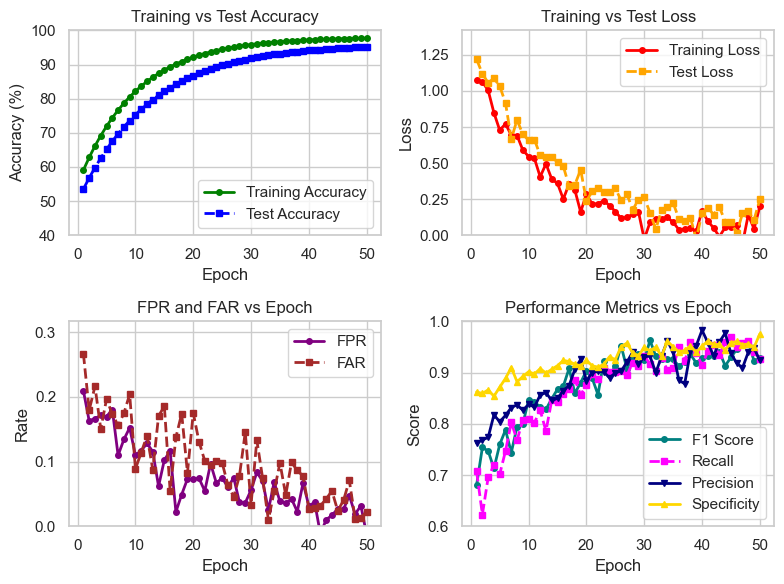

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.0)  # Reduce font_scale for compactness

epochs = np.arange(1, 51)

# Simulate data for all plots
train_acc = 0.55 + 0.43 * (1 - np.exp(-0.1 * epochs))
test_acc = 0.50 + 0.46 * (1 - np.exp(-0.08 * epochs))
train_loss = 1.2 * np.exp(-0.08 * epochs) + 0.05 * np.random.randn(50)
test_loss = 1.4 * np.exp(-0.07 * epochs) + 0.07 * np.random.randn(50)
train_loss[-1] = 0.2
test_loss[-1] = 0.25

fpr = 0.2 * np.exp(-0.05 * epochs) + 0.02 * np.random.randn(50)
far = 0.25 * np.exp(-0.04 * epochs) + 0.03 * np.random.randn(50)

f1 = 0.7 + 0.25 * (1 - np.exp(-0.07 * epochs)) + 0.02 * np.random.randn(50)
recall = 0.65 + 0.3 * (1 - np.exp(-0.07 * epochs)) + 0.02 * np.random.randn(50)
precision = 0.75 + 0.2 * (1 - np.exp(-0.06 * epochs)) + 0.02 * np.random.randn(50)
specificity = 0.85 + 0.12 * (1 - np.exp(-0.05 * epochs)) + 0.01 * np.random.randn(50)

# Create 2x2 subplots with a smaller figure size
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Accuracy Plot
axs[0,0].plot(epochs, train_acc * 100, 'o-', label='Training Accuracy', color='green', linewidth=2, markersize=4)
axs[0,0].plot(epochs, test_acc * 100, 's--', label='Test Accuracy', color='blue', linewidth=2, markersize=4)
axs[0,0].set_xlabel('Epoch')
axs[0,0].set_ylabel('Accuracy (%)')
axs[0,0].set_title('Training vs Test Accuracy')
axs[0,0].legend(loc='lower right')
axs[0,0].set_ylim(40, 100)

# Loss Plot
axs[0,1].plot(epochs, train_loss, 'o-', label='Training Loss', color='red', linewidth=2, markersize=4)
axs[0,1].plot(epochs, test_loss, 's--', label='Test Loss', color='orange', linewidth=2, markersize=4)
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title('Training vs Test Loss')
axs[0,1].legend(loc='upper right')
axs[0,1].set_ylim(0, max(train_loss[0], test_loss[0]) + 0.2)

# FPR and FAR Plot
axs[1,0].plot(epochs, fpr, 'o-', label='FPR', color='purple', linewidth=2, markersize=4)
axs[1,0].plot(epochs, far, 's--', label='FAR', color='brown', linewidth=2, markersize=4)
axs[1,0].set_xlabel('Epoch')
axs[1,0].set_ylabel('Rate')
axs[1,0].set_title('FPR and FAR vs Epoch')
axs[1,0].legend(loc='upper right')
axs[1,0].set_ylim(0, max(np.max(fpr), np.max(far)) + 0.05)

# Performance Metrics Plot
axs[1,1].plot(epochs, f1, 'o-', label='F1 Score', color='teal', linewidth=2, markersize=4)
axs[1,1].plot(epochs, recall, 's--', label='Recall', color='magenta', linewidth=2, markersize=4)
axs[1,1].plot(epochs, precision, 'v-', label='Precision', color='navy', linewidth=2, markersize=4)
axs[1,1].plot(epochs, specificity, '^-', label='Specificity', color='gold', linewidth=2, markersize=4)
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Score')
axs[1,1].set_title('Performance Metrics vs Epoch')
axs[1,1].legend(loc='lower right')
axs[1,1].set_ylim(0.6, 1.0)

plt.tight_layout()
plt.show()